In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

In [2]:
from fastai.imports import *
from fastai.structured import *

from pandas_summary import DataFrameSummary
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from IPython.display import display

from sklearn import metrics

In [3]:
PATH = 'data/bulldozers/'

In [4]:
df_raw = pd.read_csv(f'{PATH}Train.csv', low_memory=False,
                    parse_dates=["saledate"])

In [5]:
df_raw.head()

,SalesID,SalePrice,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,saledate,...,Undercarriage_Pad_Width,Stick_Length,Thumb,Pattern_Changer,Grouser_Type,Backhoe_Mounting,Blade_Type,Travel_Controls,Differential_Type,Steering_Controls
0,1139246,66000,999089,3157,121,3.0,2004,68.0,Low,2006-11-16,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Standard,Conventional
1,1139248,57000,117657,77,121,3.0,1996,4640.0,Low,2004-03-26,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Standard,Conventional
2,1139249,10000,434808,7009,121,3.0,2001,2838.0,High,2004-02-26,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1139251,38500,1026470,332,121,3.0,2001,3486.0,High,2011-05-19,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1139253,11000,1057373,17311,121,3.0,2007,722.0,Medium,2009-07-23,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 401125 entries, 0 to 401124
Data columns (total 53 columns):
SalesID                     401125 non-null int64
SalePrice                   401125 non-null int64
MachineID                   401125 non-null int64
ModelID                     401125 non-null int64
datasource                  401125 non-null int64
auctioneerID                380989 non-null float64
YearMade                    401125 non-null int64
MachineHoursCurrentMeter    142765 non-null float64
UsageBand                   69639 non-null object
saledate                    401125 non-null datetime64[ns]
fiModelDesc                 401125 non-null object
fiBaseModel                 401125 non-null object
fiSecondaryDesc             263934 non-null object
fiModelSeries               56908 non-null object
fiModelDescriptor           71919 non-null object
ProductSize                 190350 non-null object
fiProductClassDesc          401125 non-null object
state                

In [7]:
df_raw.describe()

,SalesID,SalePrice,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter
count,4.011250e+05,401125.000000,4.011250e+05,401125.000000,401125.000000,380989.000000,401125.000000,1.427650e+05
mean,1.919713e+06,31099.712848,1.217903e+06,6889.702980,134.665810,6.556040,1899.156901,3.457955e+03
std,9.090215e+05,23036.898502,4.409920e+05,6221.777842,8.962237,16.976779,291.797469,2.759026e+04
min,1.139246e+06,4750.000000,0.000000e+00,28.000000,121.000000,0.000000,1000.000000,0.000000e+00
25%,1.418371e+06,14500.000000,1.088697e+06,3259.000000,132.000000,1.000000,1985.000000,0.000000e+00
50%,1.639422e+06,24000.000000,1.279490e+06,4604.000000,132.000000,2.000000,1995.000000,0.000000e+00
75%,2.242707e+06,40000.000000,1.468067e+06,8724.000000,136.000000,4.000000,2000.000000,3.025000e+03
max,6.333342e+06,142000.000000,2.486330e+06,37198.000000,172.000000,99.000000,2013.000000,2.483300e+06


In [8]:
#taking log of the dependent variable since the competetion uses RMSLE
df_raw.SalePrice = np.log(df_raw.SalePrice)

In [9]:
#Extract information from the date column
add_datepart(df_raw, 'saledate')

In [10]:
#change string columns to int categorical values
train_cats(df_raw)

In [11]:
df_raw.UsageBand.cat.categories

Index(['High', 'Low', 'Medium'], dtype='object')

In [12]:
#set categories in order
df_raw.UsageBand.cat.set_categories(['High', 'Medium', 'Low'], ordered=True, inplace=True)

In [13]:
df_raw.UsageBand = df_raw.UsageBand.cat.codes

In [14]:
#check if there are null records
df_raw.isnull().sum().sort_index()

Backhoe_Mounting            322453
Blade_Extension             375906
Blade_Type                  321292
Blade_Width                 375906
Coupler                     187173
Coupler_System              357667
Differential_Type           331714
Drive_System                296764
Enclosure                      325
Enclosure_Type              375906
Engine_Horsepower           375906
Forks                       209048
Grouser_Tracks              357763
Grouser_Type                301972
Hydraulics                   80555
Hydraulics_Flow             357763
MachineHoursCurrentMeter    258360
MachineID                        0
ModelID                          0
Pad_Type                    321991
Pattern_Changer             301907
ProductGroup                     0
ProductGroupDesc                 0
ProductSize                 210775
Pushblock                   375906
Ride_Control                252519
Ripper                      296988
SalePrice                        0
SalesID             

In [15]:
#pre processing the data frame, separating dependent variable, numericalize,  etc
df, y, nas = proc_df(df_raw, 'SalePrice')

In [16]:
#split data into train and validations set

def split_Vals(a, n):
    return a[:n].copy(), a[n:].copy()

n_valid = 12000
n_train = len(df) - n_valid
raw_train, raw_valid = split_Vals(df_raw, n_train)
X_train, X_valid = split_Vals(df, n_train)
y_train, y_valid = split_Vals(y, n_train)

X_train.shape, y_train.shape, X_valid.shape, y_valid.shape

((389125, 66), (389125,), (12000, 66), (12000,))

In [17]:
#calculate scores

def rmse(x,y):
    return  math.sqrt(((x-y)**2).mean())

def print_score(m):
    result = [rmse(m.predict(X_train), y_train),
              rmse(m.predict(X_valid), y_valid),
              m.score(X_train, y_train),
              m.score(X_valid, y_valid)]
    
    if hasattr(m, 'oob_score__'):
        result.append(m.oob_score_)
    print(result)

In [18]:
#RandomForest with default parameters
m = RandomForestRegressor(n_jobs=-1)
m.fit(X_train, y_train)
print_score(m)

/home/mehtasham/anaconda3/envs/fastai/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[0.09057042348169243, 0.25142966347329054, 0.9828561790274406, 0.887103363791782]


In [19]:
#using a subset of training data to speed up things
df_trn, y_trn, nas = proc_df(df_raw, 'SalePrice', subset=30000, na_dict=nas)

X_train, _ = split_Vals(df_trn, 20000)
y_train, _ = split_Vals(y_trn, 20000)

In [20]:
m = RandomForestRegressor(n_jobs=-1)
m.fit(X_train, y_train)
print_score(m)

/home/mehtasham/anaconda3/envs/fastai/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[0.11277976630121561, 0.36606016154201615, 0.9721194559921418, 0.7606943744480483]


In [21]:
#using 100 trees
m = RandomForestRegressor(n_estimators=100, n_jobs=-1)
m.fit(X_train, y_train)
print_score(m)

[0.0937901260088055, 0.3491784446113347, 0.980717954579373, 0.7822576898850231]


In [22]:
#using 40 trees
m = RandomForestRegressor(n_estimators=40, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

[0.09735486733388422, 0.34797779643861576, 0.9792243700355702, 0.7837525269501382]


In [23]:
reset_rf_samples()

In [24]:
#using full dataset
df_trn, y_trn, nas = proc_df(df_raw, 'SalePrice')
X_train, X_valid = split_Vals(df_trn, n_train)
y_train, y_valid = split_Vals(y_trn, n_train)

In [25]:
#using oob score
m = RandomForestRegressor(n_estimators=40, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

[0.07848790457789738, 0.23846770701853467, 0.9871252058055098, 0.8984436402083261]


In [26]:
m = RandomForestRegressor(n_estimators=40, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

[0.07853986803866056, 0.2376473238746022, 0.9871081524689262, 0.8991411922188869]


In [27]:
#setting min sample leaf hyper parameter
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=5, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

[0.14064526720256884, 0.23316405970598894, 0.9586586103379714, 0.902910740052109]


In [28]:
#setting max feature hyper parameter
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.5, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

[0.11928998188553117, 0.227508116717273, 0.970259876246654, 0.9075638678415296]


In [29]:
#finding feature importance
fi = rf_feat_importance(m, df_trn); fi[:10]

,cols,imp
5,YearMade,0.172602
37,Coupler_System,0.107268
13,ProductSize,0.091629
14,fiProductClassDesc,0.082517
2,ModelID,0.057336
63,saleElapsed,0.053515
39,Hydraulics_Flow,0.053436
10,fiSecondaryDesc,0.048113
38,Grouser_Tracks,0.038885
19,Enclosure,0.035274


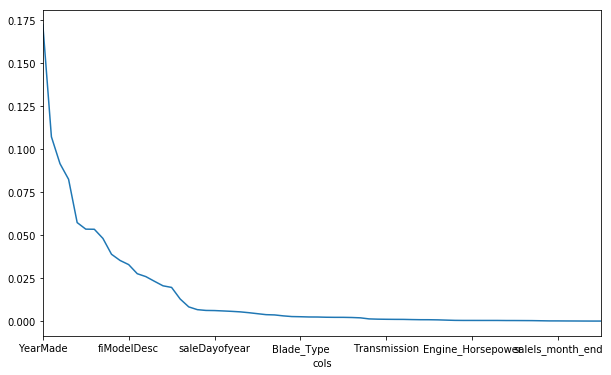

In [30]:
fi.plot('cols', 'imp', figsize=(10,6), legend=False);

In [31]:
def plot_fi(fi): return fi.plot('cols', 'imp', 'barh', figsize=(12,7), legend=False)

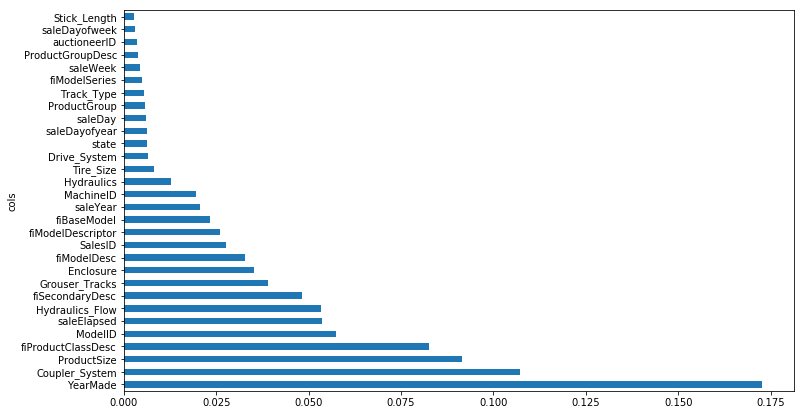

In [32]:
plot_fi(fi[:30]);

In [33]:
to_keep = fi[fi.imp>0.005].cols; len(to_keep)

24

In [34]:
df_keep = df_trn[to_keep].copy()
X_train, X_valid = split_Vals(df_keep, n_train)

In [35]:
#using only important features
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.5,
                          n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

[0.12391321978222815, 0.22482672075008, 0.9679099709756523, 0.9097299202629883]
